# Introdução

Nesse notebook vamos analisar os resultados obtidos.

# Import e EDA

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [33]:
df = pd.read_csv("data/results_experimento.csv")

df.info()

<class 'pandas.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   video              150 non-null    str    
 1   y_real             150 non-null    str    
 2   y_pred             95 non-null     str    
 3   timestamp_predito  95 non-null     float64
 4   timestamp_total    150 non-null    float64
 5   antecedencia       95 non-null     float64
 6   fps_medio          150 non-null    float64
dtypes: float64(4), str(3)
memory usage: 8.3 KB


Em 55 vídeos, o modelo não conseguiu se decidir, isso é quase um terço de todos os dados.

In [34]:
df_decided = df.dropna()

np.sum(df_decided["y_pred"] == df_decided["y_real"]) / len(df_decided)

np.float64(0.4631578947368421)

Considerando que temos uma hipótese de um modelo ingênuo com probabilidade de 1/3, a acurácia do nosso modelo em decisão tem um ganho de praticamente 13% de certeza.

In [35]:
print(df_decided["y_pred"].value_counts(normalize=True),
df_decided["y_real"].value_counts(normalize=True))

y_pred
left     0.715789
right    0.284211
Name: proportion, dtype: float64 y_real
right     0.526316
left      0.368421
center    0.105263
Name: proportion, dtype: float64


Como previmos, nosso modelo tem um problema forte em qualificar chutes no meio e um viés de classificar chutes na esquerda.

In [36]:
df[["antecedencia", "timestamp_total", "timestamp_predito"]].describe()

,antecedencia,timestamp_total,timestamp_predito
count,95.000000,150.000000,95.000000
mean,3.688508,5.257830,1.970192
std,2.208594,2.186374,1.453613
min,0.080000,2.040000,0.482759
25%,1.920000,3.480000,0.700000
50%,3.600000,5.000000,1.600000
75%,5.220000,6.470000,2.720000
max,9.280000,11.080000,7.360000


O modelo está predizendo com praticamente 2 segundos de vídeo em média, onde a média de duração do vídeo é 5 segundos.

Text(0, 0.5, 'Antecedência (s)')

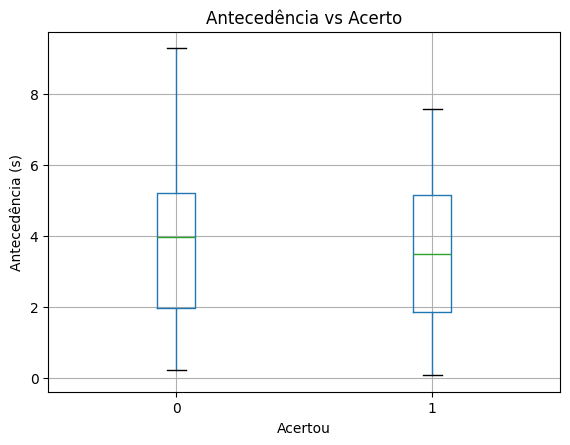

In [47]:
df_decided["acertou"] = np.where(df_decided["y_pred"] == df_decided["y_real"], 1, 0)

df_decided.boxplot(column="antecedencia", by="acertou")
plt.title("Antecedência vs Acerto")
plt.suptitle("")
plt.xlabel("Acertou")
plt.ylabel("Antecedência (s)")


Pelo gráfico, vemos que a distribuição de acertos é menor que não acertos, ou seja, a tendência é quanto menos o modelo se antecipar para acertar a cobrança, mais ele acertará, o que faz sentido.

In [51]:
df_decided.groupby("acertou").agg({"antecedencia": ["mean", "median", "std"]})

antecedencia                 
                mean median       std
acertou                              
0           3.788641   3.96  2.328182
1           3.572445   3.50  2.082015

Existe diferença, mas não é a causa principal, como vimos quando montávamos o modelo, a má distribuição dos dados acarretou em um modelo enviesado.

In [55]:
grupo_acertou = df_decided.loc[df_decided["acertou"] == 1, "antecedencia"]
grupo_errou = df_decided.loc[df_decided["acertou"] == 0, "antecedencia"]

u_stat, p_value = stats.mannwhitneyu(grupo_acertou, grupo_errou, alternative='two-sided')
print(f"U-statistic: {u_stat}, p-value: {p_value:.4f}")

U-statistic: 1080.0, p-value: 0.7568


O p-value = 0.7568 é bem maior que 0.05, o que significa que não há evidência estatística para afirmar que a antecedência média difere entre acertos e erros.

In [ ]:
df_decided.groupby("y_real")["acertou"].mean()

y_real
center    0.000000
left      0.771429
right     0.340000
Name: acertou, dtype: float64

# Conclusão

A análise da antecedência do modelo ao prever a direção dos chutes mostrou que, em média, o modelo tende a decidir com aproximadamente 3,7 frames de antecedência em relação ao final do vídeo. Apesar de visualmente parecer haver uma diferença entre os casos em que o modelo acerta ou erra, o teste de Mann-Whitney indicou que essa diferença não é estatisticamente significativa (p = 0,7568). Isso sugere que o tempo de decisão, por si só, não explica a precisão do modelo. Observou-se também que o modelo tem maior dificuldade em identificar chutes para o centro, o que é consistente com a menor representatividade desses exemplos no conjunto de treino. Como melhorias futuras, seria possível balancear melhor os dados de treino, ajustar os thresholds de decisão para forçar predições mesmo em cenários de baixa confiança, e explorar features adicionais que capturem sinais sutis do movimento do jogador, a fim de aumentar tanto a taxa de decisão quanto a acurácia geral.